In [1]:
import numpy as np
import glob
import scipy.io as sio
import torch
from torch import nn
import random
import csv
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import yaml
from evaluate import error
import time
import re
from syn_DI_dataset import make_dataset, make_dataloader
import matplotlib.pyplot as plt

In [2]:
dataset_root = 'd:\Data\My_MMFi_Data\MMFi_Dataset'
# xian zai shi yong de shi Radar_Fused
with open('config.yaml', 'r') as fd:
    config = yaml.load(fd, Loader=yaml.FullLoader)

train_dataset, val_dataset = make_dataset(dataset_root, config)

['rgb', 'depth', 'lidar', 'mmwave']
S02 ['A01', 'A02', 'A03', 'A04', 'A06', 'A08', 'A09', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A26']
S03 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A15', 'A16', 'A17', 'A18', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S05 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A19', 'A20', 'A21', 'A24', 'A25']
S06 ['A01', 'A03', 'A04', 'A06', 'A07', 'A08', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A18', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S08 ['A01', 'A02', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A13', 'A14', 'A17', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S09 ['A01', 'A07', 'A08', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18', 'A20', 'A21', 'A24', 'A25', 'A27']
S11 ['A01', 'A02', 'A03', 'A05', 'A06', 'A08', 'A10', 'A11', 'A12', 'A13', 'A16'

In [3]:
def generate_none_empth_modality_list():
    modality_list = random.choices(
        [True, False],
        k= 5,
        weights=[80, 20]
    )
    if sum(modality_list) == 0:
        modality_list = generate_none_empth_modality_list()
        return modality_list
    else:
        return modality_list


def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    dict_keys(['modality', 'scene', 'subject', 'action', 'idx', 'output', 
    'input_rgb', 'input_depth', 'input_lidar', 'input_mmwave'])
    '''
    ## get sequence lengths
    # for t in batch:
    #     print(t.keys())
    #     print(a)
    # #     # print(t[0].shape,t[1].shape)
    all_actions = {'A01': 0., 'A02': 1., 'A03': 2., 'A04': 3., 'A05': 4., 
                   'A06': 5., 'A07': 6., 'A08': 7., 'A09': 8., 'A10': 9.,
                   'A11': 10., 'A12': 11., 'A13': 12., 'A14': 13., 'A15': 14., 
                   'A16': 15., 'A17': 16., 'A18': 17., 'A19': 18., 'A20': 19., 
                   'A21': 20., 'A22': 21., 'A23': 22., 'A24': 23., 'A25': 24., 
                   'A26': 25., 'A27': 26.}
    # kpts = []
    # [kpts.append(np.array(t['output'])) for t in batch]
    # kpts = torch.FloatTensor(np.array(kpts))
    labels = []
    [labels.append(all_actions[t['action']]) for t in batch]
    labels = torch.FloatTensor(labels)

    lengths = torch.tensor([t['input_mmwave'].shape[0] for t in batch ])

    # rgb
    rgb_data = np.array([(t['input_rgb']) for t in batch ])
    rgb_data = torch.FloatTensor(rgb_data).permute(0,3,1,2)

    # depth
    depth_data = np.array([(t['input_depth']) for t in batch ])
    depth_data = torch.FloatTensor(depth_data).permute(0,3,1,2)

    # mmwave
    ## padd
    mmwave_data = [torch.Tensor(t['input_mmwave']) for t in batch ]
    mmwave_data = torch.nn.utils.rnn.pad_sequence(mmwave_data)
    ## compute mask
    mmwave_data = mmwave_data.permute(1,0,2)

    # lidar
    ## padd
    lidar_data = [torch.Tensor(t['input_lidar']) for t in batch ]
    lidar_data = torch.nn.utils.rnn.pad_sequence(lidar_data)
    ## compute mask
    lidar_data = lidar_data.permute(1,0,2)

    # wifi-csi
    # wifi_data = np.array([(t['input_wifi-csi']) for t in batch ])
    # wifi_data = torch.FloatTensor(wifi_data)
    
    modality_list = ['False', 'False', 'False', 'False', 'True']

    return rgb_data, depth_data, lidar_data, mmwave_data, labels, modality_list

In [4]:
rng_generator = torch.manual_seed(config['init_rand_seed'])
train_loader = make_dataloader(train_dataset, is_training=True, generator=rng_generator, **config['loader'], collate_fn = collate_fn_padd)
val_loader = make_dataloader(val_dataset, is_training=False, generator=rng_generator, **config['loader'], collate_fn = collate_fn_padd)

In [5]:
from MI_model_5_4input_exp import modality_invariant_model
# from MI_model_5_4input import modality_invariant_model
# from MI_model import modality_invariant_model

model = modality_invariant_model(model_depth=4)
model.cuda()

modality_invariant_model(
  (feature_extractor): feature_extrator(
    (rgb_extractor): rgb_feature_extractor(
      (part): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 3, kernel_size=(14, 14), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(3, 3, kernel_size=(5, 56), stride=(1, 1))
          (3): ReLU()
          (4): Conv2d(3, 3, kernel_size=(5, 23), stride=(1, 1))
          (5): ReLU()
          (6): Conv2d(3, 16, kernel_size=(3, 14), stride=(1, 1))
        )
        (1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (5): Sequential(
          (0): Block(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [6]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
parameter_dir = './HAR_30thAug_Model5_dep4(1).pt'
model.load_state_dict(torch.load(parameter_dir))

<All keys matched successfully>

In [9]:
def test(model, tensor_loader, criterion, device):
    model.eval()
    test_acc = 0
    test_loss = 0
    random.seed(config['modality_existances']['val_random_seed'])
    i = 0
    for data in tqdm(tensor_loader):
        start_time = time.time()
        rgb_data, depth_data, lidar_data, mmwave_data, label, modality_list = data
        # t1 = time.time()
        # load_time = t1 - start_time 
        modality_list = [True, True, True, True]
        rgb_data = rgb_data.to(device)
        depth_data = depth_data.to(device)
        lidar_data = lidar_data.to(device)
        mmwave_data = mmwave_data.to(device)
        # wifi_data = wifi_data.to(device)
        label.to(device)
        labels = label.type(torch.LongTensor)
        outputs = model(rgb_data, depth_data,  mmwave_data, lidar_data, modality_list)
        outputs = outputs.type(torch.FloatTensor)
        outputs.to(device)
        # t2 = time.time()
        # forward_time = t2 - t1
        loss = criterion(outputs,labels)
        predict_y = torch.argmax(outputs,dim=1).to(device)
        accuracy = (predict_y == labels.to(device)).sum().item()/labels.size(0)
        test_acc += accuracy
        test_loss += loss.item() * labels.size(0)

        # outputs = outputs.detach().cpu().numpy()
        # labels = labels.cpu().numpy()
        # t3 = time.time()
        # record_time = t3 - t2
        # print('load_time: ', load_time)
        # print('forward_time: ', forward_time)
        # print('record_time: ', record_time)
        if i % 100 == 0:
            print('accuracy: ', test_acc/(i+1))
        i += 1
    test_acc = test_acc/len(tensor_loader)
    test_loss = test_loss/len(tensor_loader.dataset)
    print("validation accuracy:{:.4f}, loss:{:.5f}".format(float(test_acc),float(test_loss)))
    return test_acc

In [10]:
test(model, val_loader, criterion, device)

  0%|          | 1/3403 [00:00<36:36,  1.55it/s]

accuracy:  1.0


  3%|▎         | 101/3403 [00:49<29:46,  1.85it/s]

accuracy:  0.8391089108910891


  6%|▌         | 201/3403 [01:36<22:59,  2.32it/s]

accuracy:  0.8351990049751243


  9%|▉         | 301/3403 [03:23<55:30,  1.07s/it]  

accuracy:  0.7778239202657807


 12%|█▏        | 401/3403 [05:13<51:47,  1.04s/it]  

accuracy:  0.7593516209476309


 15%|█▍        | 501/3403 [07:04<55:37,  1.15s/it]  

accuracy:  0.7407684630738522


 18%|█▊        | 601/3403 [09:02<1:07:33,  1.45s/it]

accuracy:  0.7024750415973378


 19%|█▉        | 657/3403 [10:17<43:02,  1.06it/s]  


OutOfMemoryError: CUDA out of memory. Tried to allocate 708.00 MiB. GPU 0 has a total capacty of 23.99 GiB of which 0 bytes is free. Of the allocated memory 21.23 GiB is allocated by PyTorch, and 1.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
for i, data in tqdm(enumerate(val_loader)):
    start_time = time.time()
    modality_list = [True, True, True, True]
    rgb_data, depth_data, lidar_data, mmwave_data, label, _ = data
    # t1 = time.time()
    # load_time = t1 - start_time 
    rgb_data = rgb_data.to(device)
    depth_data = depth_data.to(device)
    lidar_data = lidar_data.to(device)
    mmwave_data = mmwave_data.to(device)
    # wifi_data = wifi_data.to(device)
    label.to(device)
    labels = label.type(torch.LongTensor)
    out, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding = model(rgb_data, depth_data,  mmwave_data, lidar_data, modality_list)
    outputs = out.type(torch.FloatTensor)
    if i == 0:
        break

0it [00:00, ?it/s]


In [8]:
predict_y = out.argmax(dim=1).detach().cpu()
accuracy = (predict_y == labels).sum().item()/labels.size(0)
print('accuracy: ', accuracy)

accuracy:  0.8125


In [28]:
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [29]:
print(len(feature_list))
print(projected_features.shape)

4
torch.Size([16, 128, 512])


In [30]:
def show_image(image):
    img = np.asarray(image)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def show_image2(image1, image2, alpha=0.8):
    img1 = np.asarray(image1)
    img2 = np.asarray(image2)
    plt.figure(figsize=(100, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

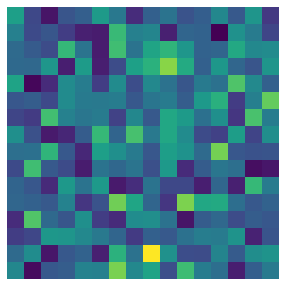

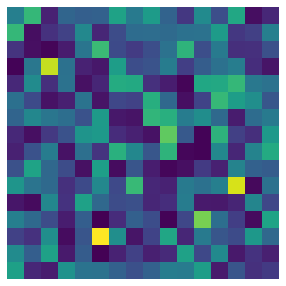

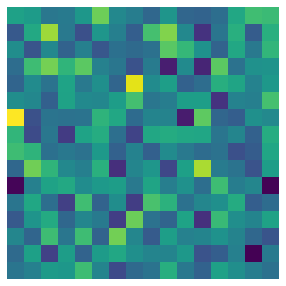

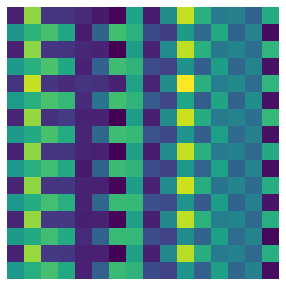

In [31]:
rgb_feature = feature_list[0]
depth_feature = feature_list[1]
mmwave_feature = feature_list[2]
lidar_feature = feature_list[3]

pool = nn.AdaptiveAvgPool1d(256)

rgb_sample = torch.mean(torch.mean(pool(rgb_feature), dim=0), dim=0).reshape(16,16)
depth_sample = torch.mean(torch.mean(pool(depth_feature), dim=0), dim=0).reshape(16,16)
mmwave_sample = torch.mean(torch.mean(pool(mmwave_feature), dim=0), dim=0).reshape(16,16)
lidar_sample = torch.mean(torch.mean(pool(lidar_feature), dim=0), dim=0).reshape(16,16)

show_image(rgb_sample.detach().cpu())
show_image(depth_sample.detach().cpu())
show_image(mmwave_sample.detach().cpu())
show_image(lidar_sample.detach().cpu())

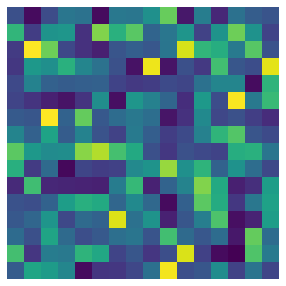

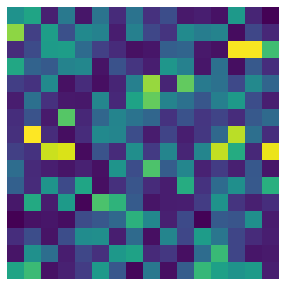

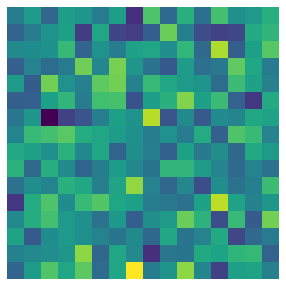

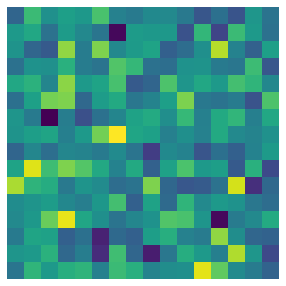

In [32]:
# out, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding
projected_features_list = list(projected_features.chunk(4, dim = 1))
rgb_projected = projected_features_list[0]
depth_projected = projected_features_list[1]
mmwave_projected = projected_features_list[2]
lidar_projected = projected_features_list[3]

pool = nn.AdaptiveAvgPool1d(256)

# rgb_projected_sample = rgb_projected[0]
# depth_projected_sample = depth_projected[0]
# lidar_projected_sample = lidar_projected[0]
# mmwave_projected_sample = mmwave_projected[0]
# rgb_projected_sample = pool(torch.mean(rgb_projected, dim=0))
# depth_projected_sample = pool(torch.mean(depth_projected, dim=0))
# lidar_projected_sample = pool(torch.mean(lidar_projected, dim=0))
# mmwave_projected_sample = pool(torch.mean(mmwave_projected, dim=0))
rgb_projected_sample = torch.mean(pool(torch.mean(rgb_projected, dim=0)), dim=0).reshape(16,16)
depth_projected_sample = torch.mean(pool(torch.mean(depth_projected, dim=0)), dim=0).reshape(16,16)
lidar_projected_sample = torch.mean(pool(torch.mean(lidar_projected, dim=0)), dim=0).reshape(16,16)
mmwave_projected_sample = torch.mean(pool(torch.mean(mmwave_projected, dim=0)), dim=0).reshape(16,16)


show_image(rgb_projected_sample.detach().cpu())
show_image(depth_projected_sample.detach().cpu())
show_image(mmwave_projected_sample.detach().cpu())
show_image(lidar_projected_sample.detach().cpu())

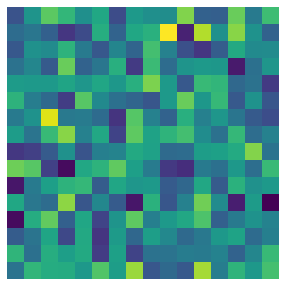

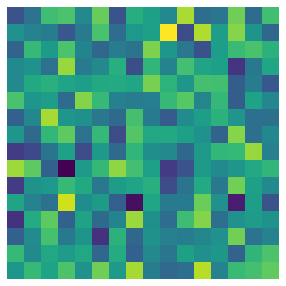

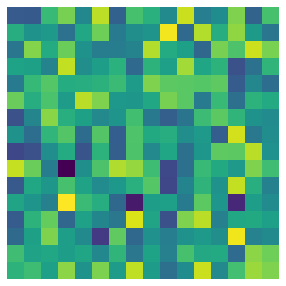

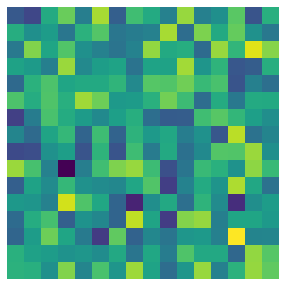

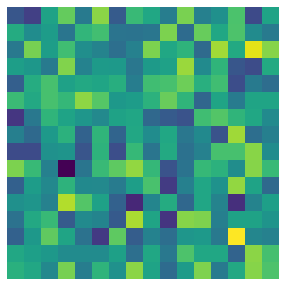

In [33]:
# print(cross_modal_embedding.shape)
cross_modal_embedding_layer_0 = cross_modal_embedding["layer0"]
cross_modal_embedding_layer_1 = cross_modal_embedding["layer1"]
cross_modal_embedding_layer_2 = cross_modal_embedding["layer2"]
cross_modal_embedding_layer_3 = cross_modal_embedding["layer3"]
cross_modal_embedding_layer_4 = cross_modal_embedding["layer4"]

pool = nn.AdaptiveAvgPool1d(256)

# cross_modal_embedding_0_sample = pool(torch.mean(cross_modal_embedding_layer_0, dim=0))
# cross_modal_embedding_1_sample = pool(torch.mean(cross_modal_embedding_layer_1, dim=0))
# cross_modal_embedding_2_sample = pool(torch.mean(cross_modal_embedding_layer_2, dim=0))
# cross_modal_embedding_3_sample = pool(torch.mean(cross_modal_embedding_layer_3, dim=0))
cross_modal_embedding_0_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_0, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_1_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_1, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_2_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_2, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_3_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_3, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_4_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_4, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_0_sample.detach().cpu())
show_image(cross_modal_embedding_1_sample.detach().cpu())
show_image(cross_modal_embedding_2_sample.detach().cpu())
show_image(cross_modal_embedding_3_sample.detach().cpu())
show_image(cross_modal_embedding_4_sample.detach().cpu())

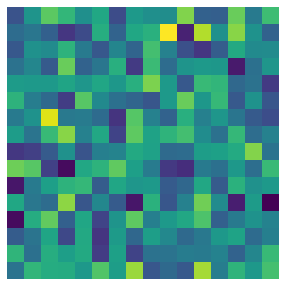

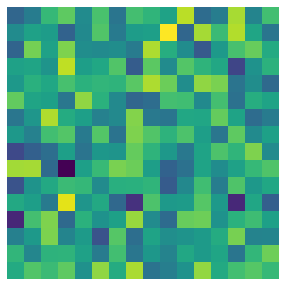

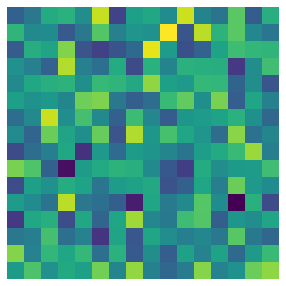

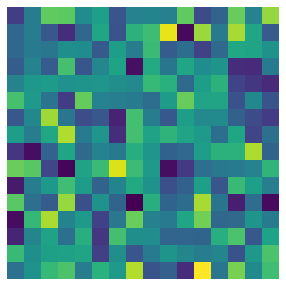

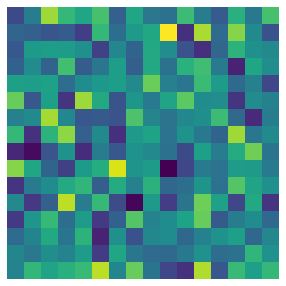

In [34]:
cross_attention_embedding_layer_0 = cross_attention_embedding["layer1"]
# cross_attention_embedding_layer_1 = cross_attention_embedding["layer1"]
# cross_attention_embedding_layer_2 = cross_attention_embedding["layer2"]

modal_features_list = list(cross_attention_embedding_layer_0.chunk(4, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]

pool = nn.AdaptiveAvgPool1d(256)

# rgb_injected_sample = rgb_injected[0]
# depth_injected_sample = depth_injected[0]
# lidar_injected_sample = lidar_injected[0]
# mmwave_injected_sample = mmwave_injected[0]
# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))
rgb_injected_sample_0 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_0 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_0 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_0 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)

# show_image2(rgb_sample.detach().cpu(), rgb_injected_sample.detach().cpu())
show_image(cross_modal_embedding_0_sample.detach().cpu())
show_image(rgb_injected_sample_0.detach().cpu())
show_image(depth_injected_sample_0.detach().cpu())
show_image(mmwave_injected_sample_0.detach().cpu())
show_image(lidar_injected_sample_0.detach().cpu())

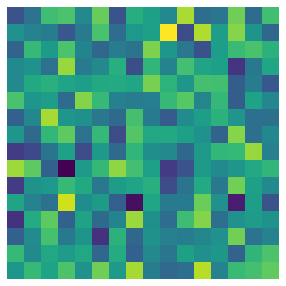

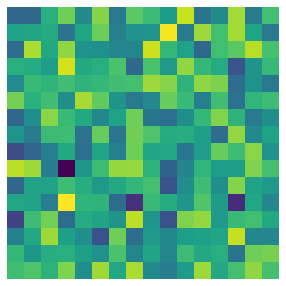

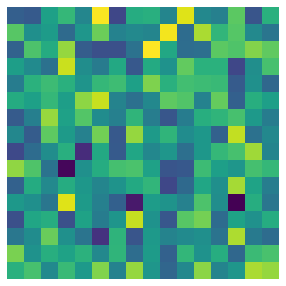

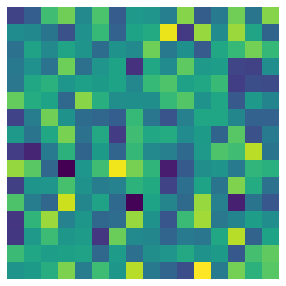

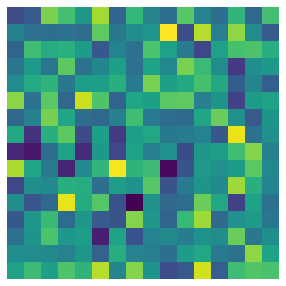

In [35]:
cross_attention_embedding_layer_1 = cross_attention_embedding["layer2"]

modal_features_list = list(cross_attention_embedding_layer_1.chunk(4, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]

# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))

rgb_injected_sample_1 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_1 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_1 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_1 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_1_sample.detach().cpu())
show_image(rgb_injected_sample_1.detach().cpu())
show_image(depth_injected_sample_1.detach().cpu())
show_image(mmwave_injected_sample_1.detach().cpu())
show_image(lidar_injected_sample_1.detach().cpu())

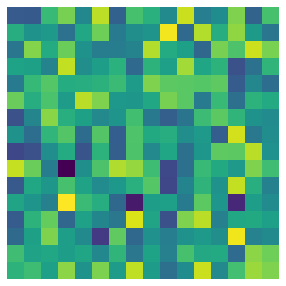

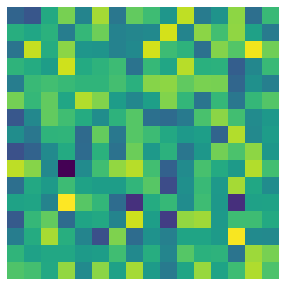

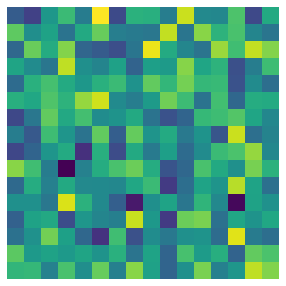

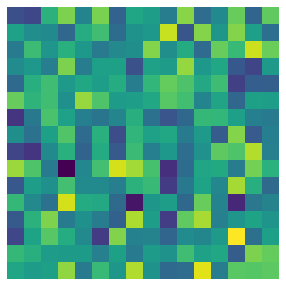

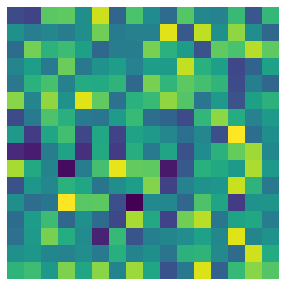

In [36]:
cross_attention_embedding_layer_2 = cross_attention_embedding["layer3"]

modal_features_list = list(cross_attention_embedding_layer_2.chunk(4, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]

# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))

rgb_injected_sample_2 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_2 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_2 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_2 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_2_sample.detach().cpu())
show_image(rgb_injected_sample_2.detach().cpu())
show_image(depth_injected_sample_2.detach().cpu())
show_image(mmwave_injected_sample_2.detach().cpu())
show_image(lidar_injected_sample_2.detach().cpu())

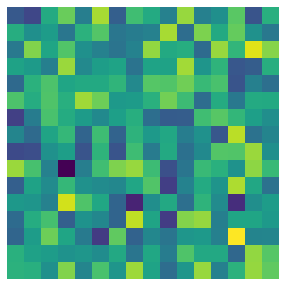

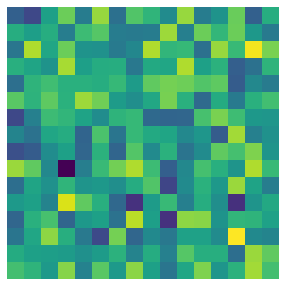

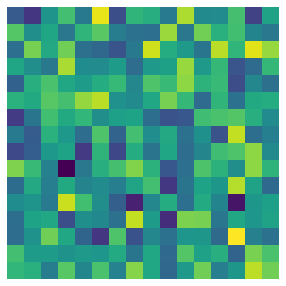

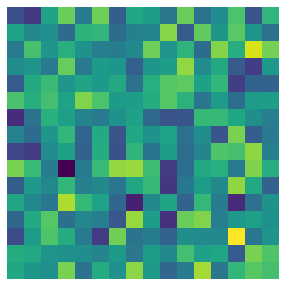

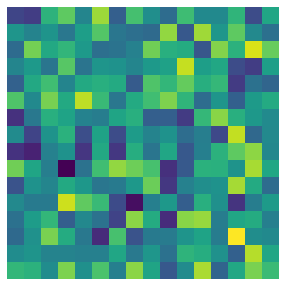

In [37]:
cross_attention_embedding_layer_3 = cross_attention_embedding["layer4"]

modal_features_list = list(cross_attention_embedding_layer_3.chunk(4, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]

rgb_injected_sample_3 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_3 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_3 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_3 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_3_sample.detach().cpu())
show_image(rgb_injected_sample_3.detach().cpu())
show_image(depth_injected_sample_3.detach().cpu())
show_image(mmwave_injected_sample_3.detach().cpu())
show_image(lidar_injected_sample_3.detach().cpu())


In [38]:
print(cross_attention_embedding.keys())
print(cross_modal_embedding.keys())

dict_keys(['layer1', 'layer2', 'layer3', 'layer4'])
dict_keys(['layer0', 'layer1', 'layer2', 'layer3', 'layer4'])


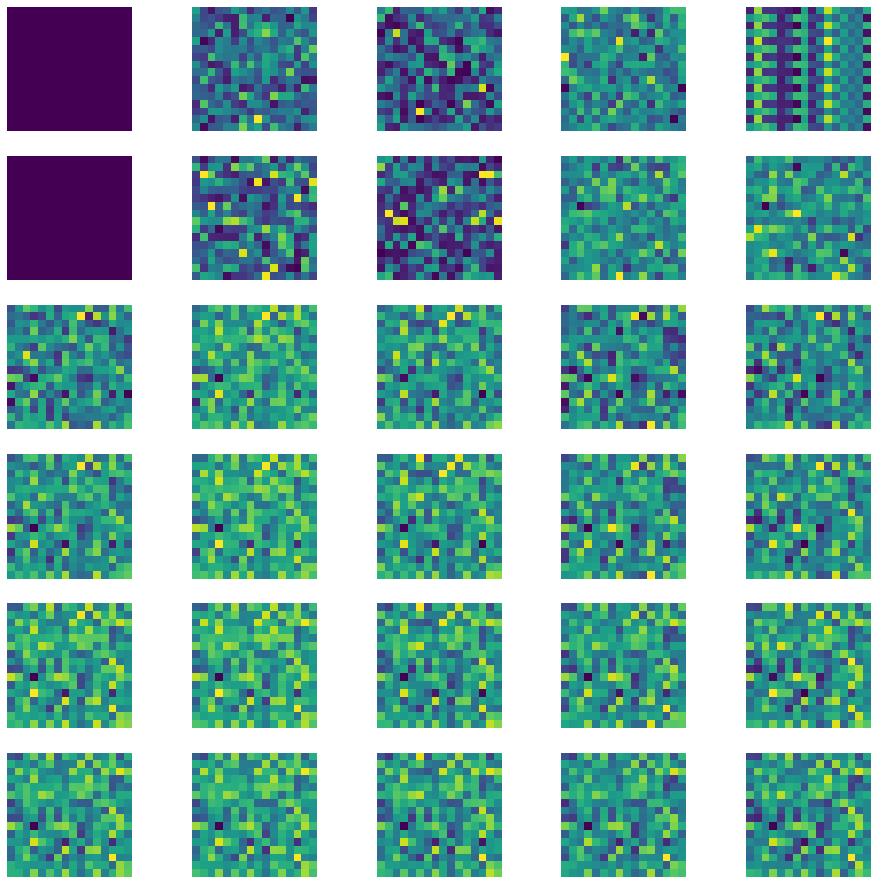

In [39]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(6, 5, 1)
blank = np.zeros((16,16))
plt.imshow(blank)
plt.axis('off')
fig.add_subplot(6, 5, 2)
plt.imshow(rgb_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 3)
plt.imshow(depth_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 4)
plt.imshow(mmwave_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 5)
plt.imshow(lidar_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 6)
plt.imshow(blank)
plt.axis('off')
fig.add_subplot(6, 5, 7)
plt.imshow(rgb_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 8)
plt.imshow(depth_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 9)
plt.imshow(mmwave_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 10)
plt.imshow(lidar_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 11)
plt.imshow(cross_modal_embedding_0_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 12)
plt.imshow(rgb_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 13)
plt.imshow(depth_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 14)
plt.imshow(mmwave_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 15)
plt.imshow(lidar_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 16)
plt.imshow(cross_modal_embedding_1_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 17)
plt.imshow(rgb_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 18)
plt.imshow(depth_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 19)
plt.imshow(mmwave_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 20)
plt.imshow(lidar_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 21)
plt.imshow(cross_modal_embedding_2_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 22)
plt.imshow(rgb_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 23)
plt.imshow(depth_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 24)
plt.imshow(mmwave_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 25)
plt.imshow(lidar_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 26)
plt.imshow(cross_modal_embedding_3_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 27)
plt.imshow(rgb_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 28)
plt.imshow(depth_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 29)
plt.imshow(mmwave_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 5, 30)
plt.imshow(lidar_injected_sample_3.detach().cpu())
plt.axis('off')
plt.show()
